In [1]:
# imports of necessary packages
from domains.CartPole import CartPole
from exploration.DecayingEpsilon import DecayingEpsilon
from agents.DeepAgent import DeepAgent
from training.Trainer import Trainer

import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2

C:\Users\Michael\Dropbox\rl\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# set up the domain
domain = CartPole()

# use default encoding for the states
encoding = domain.default_encoding

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# let's import the pre-trained networks to use as the experts
model_good = keras.models.load_model('C:\\Users\\Michael\\Dropbox'
                                     '\\rl\\notebooks\\cartpole_model_6_by_2.h5')
model_bad = keras.models.load_model('C:\\Users\\Michael\\Dropbox'
                                    '\\rl\\notebooks\\cartpole_model_64_by_3.h5')

In [4]:
# now we will define the shaping functions from these networks
def good_shape(state):
    return np.amax(model_good.predict(encoding(state))[0])

def overfit_shape(state):
    return np.amax(model_bad.predict(encoding(state))[0])

# let's define the other experts
def bad_shape(state):
    return -good_shape(state)

def zero_shape(state):
    return 0.0

def random_shape(state):
    return random.random()

In [5]:
# we will define the success criterion and stopping rule
# since we will be taking an average of many trials, we don't do early stopping
def steps_balanced(cartpole, policy, enc):
    state, rewards, steps = cartpole.rewards(500, policy, 0.95, enc)
    return steps, False

In [6]:
# set up the neural network as the function approximator
model = Sequential()
regularizer = l2(1e-6)
model.add(Dense(units=12, input_dim=domain.state_dim(),
                kernel_regularizer=regularizer))
model.add(LeakyReLU())
model.add(Dense(units=12,
                kernel_regularizer=regularizer))
model.add(LeakyReLU())
model.add(Dense(units=domain.action_count(),
                activation='linear',
                kernel_regularizer=regularizer))
model.compile(loss='mse', optimizer=Adam(lr=0.001))
print(model.summary())

# set up the exploration schedule for the greedy epsilon policy
eps_schedule = DecayingEpsilon(0.5, 0.01, 0.995)

# set up the learning agent
agent = DeepAgent(domain.state_dim(), domain.action_count(), 0.95)
agent.setup_nn(batch_size=32, 
               epochs_per_batch=1,
               memory_size=10000, 
               network=model)

# finally create the training algorithm
training = Trainer(domain, agent, encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                60        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 26        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# we start by training for 10 trials on all the experts and sarsa
experts = [zero_shape, good_shape, overfit_shape, bad_shape, random_shape]
data_sarsa = training.run_many(trials=10, epochs=125, horizon=500, 
                               exploration=eps_schedule, experts=experts,
                               method='sarsa', 
                               replay_online_every=0, replays_offline=32,
                               measure=steps_balanced)

Trial 0 complete.


Trial 1 complete.


Trial 2 complete.


Trial 3 complete.


Trial 4 complete.


Trial 5 complete.


Trial 6 complete.


Trial 7 complete.


Trial 8 complete.


Trial 9 complete.


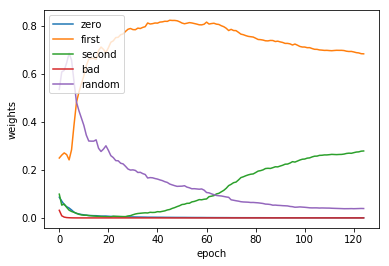

In [8]:
# now let's plot the bayesian weights
plt.xlabel('epoch')
plt.ylabel('weights')
legend_labels = ['zero', 'first', 'second', 'bad', 'random']
for i, series in enumerate(data_sarsa['weights']):
    plt.plot(series, label=legend_labels[i])
plt.legend(loc='upper left')
plt.show()

In [9]:
# so as expected the agent learns to trust the well-trained model
# interestingly, over time the agent also trusts the over-trained model
# this may be because the neural net being trained is starting to overfit as well

In [10]:
# let's compute the benchmark rewards without shaping
data_sarsa_bench = training.run_many(trials=10, epochs=125, horizon=500, 
                                     exploration=eps_schedule, experts=[zero_shape],
                                     method='sarsa', 
                                     replay_online_every=0, replays_offline=32,
                                     measure=steps_balanced)

Trial 0 complete.


Trial 1 complete.


Trial 2 complete.


Trial 3 complete.


Trial 4 complete.


Trial 5 complete.


Trial 6 complete.


Trial 7 complete.


Trial 8 complete.


Trial 9 complete.


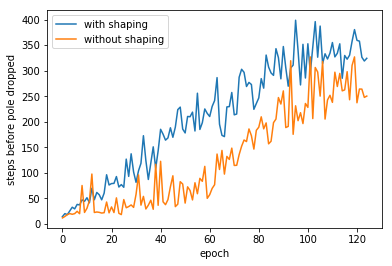

In [11]:
# let's plot the progress
plt.xlabel('epoch')
plt.ylabel('steps before pole dropped')
plt.plot(data_sarsa['measure'], label='with shaping')
plt.plot(data_sarsa_bench['measure'], label='without shaping')
plt.legend(loc='upper left')
plt.show()

In [12]:
# wow this is impressive! clearly shaping has helped because the agent
# is learning faster and also it seems the values are better on average
# i'd want to run this for more epochs to verify this